# 00.02 basics : error

##### code, setup and dependencies

In [ ]:
if True: # settings for the people
  import matplotlib.pyplot as plt
  import numpy as np
  from wordcloud import WordCloud

In [ ]:
class PlotData:
  def __init__(self,points,vectors,plabels,vlabels,overrides=None,deltas=None,dlabels=None):
    """
    points (tuple) : points [(x₀,y₀),(x₁,y₁),...]
    vectors (tuple) : path [(i₀₀,i₁₀),(i₀₁,i₁₁),...] where v₀ = p[i₀] → p[i₁]
    plabels (array-like) : point labels [plabel₀,plabel₁,...]
    vlabels (array-like) : vector labels [vlabel₀,vlabel₁,...]
    overrides (tuple, optional) : vector label offset overrides [(v₀,dv₀),(v₁,dv₁),...] where vᵢ,dvᵢ are tuples
    deltas (tuple, optional) : error spans [(i₀₀,i₁₀),(i₀₁,i₁₁),...] where Δ₀ = p[i₀] → p[i₁]
    dlabels (array-like, optional) : error span labels [dlabel₀,dlabel₁,...]
    """
    self.points = np.array(points)
    self.vectors = np.array(vectors)
    self.plabels = plabels
    self.vlabels = vlabels
    self.overrides = overrides
    self.deltas = np.array(deltas) if deltas else None
    self.dlabels = dlabels

    self._axX = 0
    self._axY = 1
    self._xmin = np.min(self.points[:,self._axX])
    self._xmax = np.max(self.points[:,self._axX])
    self._xavg = np.average(self.points[:,self._axX])
    self._ymin = np.min(self.points[:,self._axY])
    self._ymax = np.max(self.points[:,self._axY])
    self._yavg = np.average(self.points[:,self._axY])

    self.offset = (self._xmax - self._xmin)/10
    self.arrow_size = self.offset*3/5

  @property
  def center(self):
    return (self._xavg,self._yavg)
  @property
  def xs(self):
    return self.points[:,self._axX]
  @property
  def ys(self):
    return self.points[:,self._axY]
  @property
  def poffsets(self): #,offset=None):
    offsets = []

    offset = self.offset # offset if offset else self.offset

    for xy in self.points:
      dx = dy = 0
      if xy[self._axX] == self._xmin:
        dx = -offset # left
      elif xy[self._axX] == self._xmax:
        dx = +offset # right
      if xy[self._axY] == self._ymin:
        dy = -offset # bottom
      elif xy[self._axY] == self._ymax:
        dy = +offset # top
      if dx == 0 and dy == 0:
        dx = dy = -offset
      offsets += [(dx,dy)]
    return offsets
  @property
  def voffsets(self): #,offset=None):
    offsets = []

    offset = self.offset # offset if offset else self.offset

    for v in self.vectors:
      ifrom,ithru = v
      override = self.overrides.get((ifrom,ithru),None) if self.overrides else None
      if override:
        dx,dy = override; dx *= offset; dy *= offset
      else:
        dx = dy = 0
        p0,p1 = v
        xavg = (self.points[p0,self._axX]+self.points[p1,self._axX])/2
        if abs(self._xmin - xavg) < offset:
          dx = -offset # left
        elif abs(self._xmax - xavg) < offset:
          dx = +offset # right
        yavg = (self.points[p0,self._axY]+self.points[p1,self._axY])/2
        if abs(self._ymin - yavg) < offset:
          dy = -offset # bottom
        elif abs(self._ymax - yavg) < offset:
          dy = +offset # top
        if dx == 0 and dy == 0:
          dx = dy = -offset
      offsets += [(dx,dy)]
    return offsets
  @property
  def doffsets(self): #,offset=None):
    offsets = []

    offset = self.offset # offset if offset else self.offset

    for d in self.deltas:
      dx = dy = 0
      p0,p1 = d
      xavg = (self.points[p0,self._axX]+self.points[p1,self._axX])/2
      if abs(self._xmin - xavg) < offset:
        dx = -offset # left
      elif abs(self._xmax - xavg) < offset:
        dx = +offset # right
      yavg = (self.points[p0,self._axY]+self.points[p1,self._axY])/2
      if abs(self._ymin - yavg) < offset:
        dy = -offset # bottom
      elif abs(self._ymax - yavg) < offset:
        dy = +offset # top
      if dx == 0 and dy == 0:
        dx = dy = -offset
      offsets += [(dx,dy)]
    return offsets

class Plotter():
  def __init__(self):
    self.size = 2
    self.offset = self.size/20
    self._arrow_size = self.size/50

  @staticmethod
  def plotAxis(ax,data):
    if not isinstance(data, PlotData):
        raise TypeError("data must be an instance of PlotData")

    # plot, vertices
    ax.scatter(data.xs,data.ys,c="C0")
    for p,label,dp in zip(data.points,data.plabels,data.poffsets):
      x,y = p
      dpx,dpy = dp
      ha = "right" if dpx < 0 else "left"
      va = "top" if dpy < 0 else "bottom"
      ax.annotate(label,(x,y),(x+dpx/2,y+dpy/2),ha=ha,va=va)

    # plot, arrows
    for v,label,dv in zip(data.vectors,data.vlabels,data.voffsets):
      color = "black" if label.find("$\hat{\phi}$") < 0 else "grey"
      ifrom,ithru = v
      xfrom,yfrom = data.points[ifrom]
      xthru,ythru = data.points[ithru]
      dx = xthru - xfrom; dy = ythru - yfrom
      ax.arrow(xfrom,yfrom,dx,dy,color=color,head_width=data.arrow_size,length_includes_head=True)
      dvx,dvy = dv
      dx += dvx
      dy += dvy
      ha = "right" if dvx < 0 else "left"
      va = "top" if dvy < 0 else "bottom"
      ax.annotate(label,(xfrom,yfrom),(xfrom+dx/2,yfrom+dy/2),ha=ha,va=va)

    # plot, Δs
    if data.deltas is not None:
      for d,label,dd in zip(data.deltas,data.dlabels,data.doffsets):
        color = "black" if label.find("$\hat{\phi}$") < 0 else "grey"
        ifrom,ithru = d
        xfrom,yfrom = data.points[ifrom]
        xthru,ythru = data.points[ithru]
        dx = xthru - xfrom; dy = ythru - yfrom
        ax.annotate("",xy=(xfrom,yfrom),xytext=(xthru,ythru),arrowprops=dict(arrowstyle="<|-|>"))
        ddx,ddy = dd
        dx += ddx
        dy += ddy
        ha = "right" if ddx < 0 else "left"
        va = "top" if ddy < 0 else "bottom"
        ax.annotate(label,(xfrom,yfrom),(xfrom+dx/2,yfrom+dy/2),ha=ha,va=va)

    # plot, style
    ax.axis("off")


###### in order of appearance

In [ ]:
def img_fwe():
  fwe = PlotData(
    [(0,1),(1,1),(1,0)],
    [(0,1),(0,2),(2,1)],
    ["$x$","$y$, actual","$\hat{y}$, model"],
    ["$\phi$","$\hat{\phi}$","$\Delta y = |y-\hat{y}|$, fwd error"])
  plt.close("all")
  fig,axs = plt.subplots(figsize=(2,2))
  Plotter.plotAxis(ax=axs,data=fwe)
  plt.show()


In [ ]:
def img_bwe():
  bwe = PlotData(
    [(0,1),(1,1),(1,0),(0.1,0.1)],
    [(0,1),(0,2),(2,1),(0,3),(3,2)],
    ["$x$","$y$, actual","$\hat{y}$, model","$x+\Delta x$"],
    ["$\phi$","$\hat{\phi}$","$\Delta y$ = fwd error","bwd error = $\Delta x$","$\phi$"])
  plt.close("all")
  fig,axs = plt.subplots(figsize=(2,2))
  Plotter.plotAxis(ax=axs,data=bwe)
  plt.show()


In [ ]:
def img_wordsx3():
  ws_lhs = ["actual","experimental","real","reference","true"]
  ns_lhs = [30,2,1,1,6]
  ws_rhs = ["approximate","engineered","model"]
  ns_rhs = [8,2,30]
  wx = [ws_lhs,ws_rhs]
  nx = [ns_lhs,ns_rhs]

  plt.close("all")
  fig,axs = plt.subplots(1,2,figsize=(10,2))

  i = 0
  for ns,ws in zip(nx,wx):
    text = ""
    for imax,word in zip(ns,ws):
      for _ in range(imax):
        text += " " + word

    words = WordCloud(background_color="white",stopwords=[""]).generate(text)
    axs[i].imshow(words,interpolation="bilinear")
    axs[i].axis("off")
    i += 1

  plt.show()


In [ ]:
def img_nsw():
  nsw = PlotData(
    [(0.1,0.1),(1,1),(1,2),(0,1)],
    [(0,2),(2,1),(0,3),(3,1)],
    ["$x$","$y$, actual","$\hat{y}$, model","$x+\Delta x$"],
    ["$\hat{\phi}$","$\Delta y$ = fwd error","bwd error = $\Delta x$","$\phi$"],
    {(0,2):(2,8),(3,1):(-2,1)}) # vector label offset overrides
  plt.close("all")
  fig,axs = plt.subplots(figsize=(2,2))
  Plotter.plotAxis(ax=axs,data=nsw)
  plt.title("numerical stability à la wiki",pad=30)
  plt.show()


In [ ]:
def img_nsh():
  d_size = 2
  n_subplots = 3

  # plot, cfg
  plt.close("all")
  fig,axs = plt.subplots(1,n_subplots,figsize=(d_size*n_subplots,d_size))

  # image, higham, #1
  ns0 = PlotData(
      [(0,0.8),(0,0.2),(1,1),(1,0.6),(1,0)],
      [(0,2),(0,3),(1,4)],
      ["$x$","$x+\Delta x$","$y$","$\hat{y}$","$\hat{y}+\Delta y$"],
      ["$\phi$","$\hat{\phi}$","$\phi$"],
      deltas=[(0,1),(2,3),(3,4)],
      dlabels=["bwe = $\Delta x$","fwe","$\Delta y$"])
  Plotter.plotAxis(ax=axs[0],data=ns0)

  # spacer, ≈
  axs[1].text(0.3,0.5,"≈",fontsize="xx-large")

  # image, higham, #2
  ns2 = PlotData(
      [[0,1],[0,0],[1,1],[1,0]],
      [(0,2),(1,3)],
      ["$x$","$x+\Delta x$","$y$","$\hat{y}=\phi(x+\Delta x)$"],
      ["$\phi$","$\phi$"],
      deltas=[(0,1),(2,3)],
      dlabels=["bwe ≤ $\epsilon$","fwe ≤ $\eta$"])
  Plotter.plotAxis(ax=axs[2],data=ns2)
  axs[2].annotate("≈",ns2.center,ha="center")

  # plot, style
  fig.suptitle("stability: error and propagation à la higham, corliss")
  plt.subplots_adjust(top=0.70) # spacing after suptitle
  axs[0].axis("off")
  axs[1].axis("off") # lol = spacer, atm
  axs[2].axis("off")
  # plot, show
  plt.show()


## 01 quality when theres quantity

the rational number $\tfrac{1}{3}$ exists but it does not exist in the set known as FPS. instead, it is approximated by the nearest FPN. ie, hello errors.
<br/>

if mathematical operations happen to this number, then hello more errors.

## 02 notation, floating-point operators

$\circ$, "round to nearest FPN". eg, $x,y \in\mathbb{R} \mapsto \circ (x+y) = \circ(x) + \circ(y)$.
<br/>

also, $\oplus\,\ominus\,\otimes\,\oslash$ such that $x \oplus y = \circ(x+y)$. usw.

## 03 error

suppose $x \in\mathbb{R}$ and $\hat{x} \in\mathbb{FP}$ is its FPN approximation. ie, $\hat{x} = \circ x$. then
<br/>

* <b>absolute error</b>, $\Delta x = |x-\hat{x}|$ and
* <b>relative error</b>, $\delta x = \tfrac{\Delta x}{|x|}$.

rounding is an algorithm and has two kinds of error:
<br/>

1. <b>forward</b>, wrt how well the algorithm approximates the true output; and
2. <b>backward</b>, wrt how desired results relate back to expected input.

### i) forward error

suppose $x,y$ such that $\phi(x) = y$ and $\hat{\phi}(x) = \hat{y}$, where $\hat{\phi}$ is the numerical approximation to real problem $\phi$. then
<br/>

* <b>forward error</b>, $\Delta y = y - \hat{y}$;
* <b>absolute forward error</b>, $|\Delta y| = |y - \hat{y}|$; and
* <b>relative forward error</b>, $\delta y = \tfrac{|\Delta y|}{|y|}$.

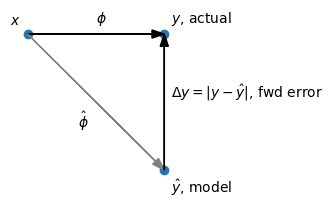

In [ ]:
img_fwe()

### ii) backward error

suppose $x, \Delta x$ such that $\hat{\phi}(x) = \hat{y} = \phi(x+\Delta x)$. then
<br/>

* <b>backward error</b>, $\Delta x = \Delta x_{\text{min}}$ where $\hat{\phi}(x) = \hat{y} = \phi(x+\Delta x)$;
* <b>absolute backward error</b>, $|\Delta x|$; and
* <b>relative backward error</b>, $\delta x = \tfrac{|\Delta x|}{|x|}$.
<br/>

ie, backward error identifies the ("nearby") problem the algorithm actually solved.

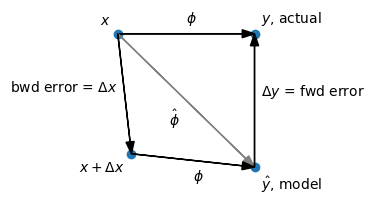

In [ ]:
img_bwe()

#### why perturb $x$ there?

why is $\Delta x$ applied to $\phi(x)$ and not $\hat{\phi}(x)$? bc perturbing the latter changes the computed approximation itself rather than identifying a nearby problem for which the original approximation is the exact solution.
<br/>

<b>backward error analysis</b> is based on the idea that numerical methods introduce errors and the goal is to understand how these errors relate to the original problem. determining the smallest perturbation $\Delta x$ that makes $\hat{\phi}(x)$ the exact solution to $\phi(x + \Delta x)$, allows quantification of the computation to see how far it has strayed from the original problem and to determine if it is still meaningful.

## 04 terminology

fyi, this course favors (albeit imperfectly) "actual problem" and "model solution".

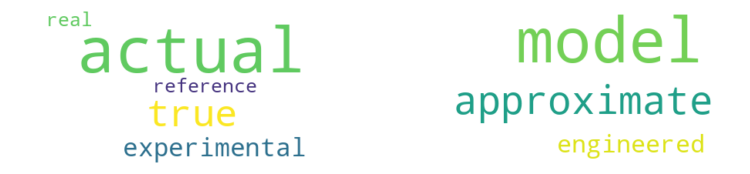

In [ ]:
img_wordsx3()

## 05 stability

### i) forward stability

an engineered solution is <b>forward stable</b> if there exists $\eta > 0$ such that $||y-\hat{y}|| \le \eta \times ||y||$.

---
however, forward error analysis is not prevalent bc "true" $\phi$ is not always readily available. eg, $\sqrt{3} \in\mathbb{R}$ but $\sqrt{3} \notin\mathbb{FP}$.
<br/>

ie, to implement an algorithm computationally, is to part ways with forward stability analysis at its abstract level. however, computationally, <b>use pythons native and/or standard libary functions to stand in for "true" $\phi$</b>.
<br/>

note: $\sqrt{3} \in\mathbb{CAS}$, where $\mathbb{CAS}$ refers to "computer algebra systems" but that is not the same as a set of numbers.

### ii) backward stability

an engineered solution is <b>backward stable</b> if there exists $\epsilon > 0$ such that $||\Delta x|| \le \epsilon \times ||x||$ where $\hat{\phi}(x) = \hat{y} = \phi(x+\Delta x)$.

### iii) numerical stability

an algorithm is of mixed stability iif there exists a $\Delta x$ such that both $\Delta x$ is small and $\phi(x+\Delta x) - \hat{y}$ is small. ie,
<br/>

an engineered solution is <b>numerically stable</b> iif there exists $\eta > 0, \epsilon > 0$ such that $\tfrac{||y - \hat{y}||}{ ||y||} \le \eta$ and $\tfrac{||\Delta x||}{||x||} \le \epsilon$, where $y = \phi(x+\Delta x)$ and $\hat{y} = \hat{\phi}(x)$.

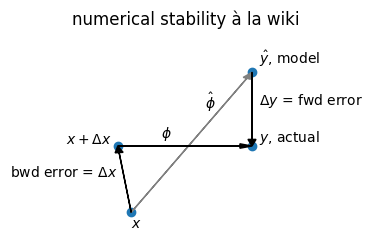

In [ ]:
img_nsw() # we dont like this one

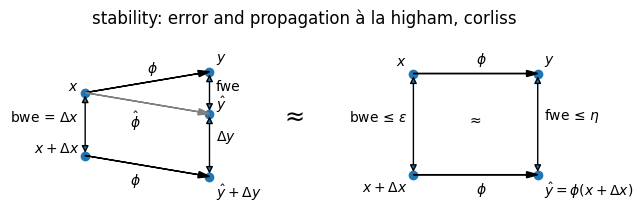

In [ ]:
img_nsh()

## 06 propagation

### i) error magnification

<b>error magnification</b>, frequently $\gamma$, relates forward and backward error wrt amplification. ie, it quantifies how small errors in input can increase in the final solution.
<br/>

\begin{align}
  \gamma &= \text{forward error} / \text{backward error} = |\Delta y| / |\Delta x| \\
  \\
  &\Downarrow \quad\text{or more formally} \\
  \\
  &= \lim_{\Delta x\rightarrow 0}\, \text{sup}_{\Delta x \le \epsilon}\, |\Delta y|/|\Delta x|.
\end{align}

### ii) condition number

<b>condition number</b>, frequently $\kappa$, relates forward and backward error wrt likelihood. ie, it quantifies how small perturbations in input affect the final solution.
<br/>

\begin{align}
  \kappa &= \text{relative forward error} / \text{relative backward error} = |\delta y| / |\delta x| \\
  \\
  &\Downarrow \quad\text{or more formally} \\
  \\
  &= \lim_{\Delta x\rightarrow 0}\, \text{sup}_{\Delta x \le \epsilon}\, [\,|\Delta y| / |y|\,] / [\,|\Delta x| / |x|\,].
\end{align}
<br/>

a small condition number indicates a "well-conditioned" system and a large condition number indicates an "ill-conditioned" system wrt stability.

##### example 01

consider perturbations wrt $p(x) = 17x^3 + 11x^2 + 2 \Rightarrow \Delta y$.

\begin{align}
  \Delta y &= p(x + \Delta x) - p(x) \\
  &= [17(x+\Delta x)^3 + 11(x+\Delta x)^2 + 2] - [17x^3 + 11x^2 + 2] \\
  &= 51x^2\Delta x + 51x(\Delta x)^2 + 17(\Delta x)^3 + 22x(\Delta x) + 11(\Delta x)^2 \\
  \\
  &\Downarrow \quad|\Delta x| \ll 1 \text{, disregard higher orders of } \Delta x \\
  \\
  \Delta y &\approx 51x^2\Delta x + 22x\Delta x. \\
  \\
  &\Downarrow \quad\text{consider } x = 1 \pm 0.1 \\
  \\
  \Delta y &\approx 30 \pm 7.3.
\end{align}

$p(1) = 30$, so the $\pm 7.1$ that results from $\Delta x = \pm 0.1$ is inherent to this $p(x)$.
<br/>

consider $1$ as an ideal upper bound for $\kappa$.
<br/>

\begin{align}
  \kappa_{\text{REL}} &= |\delta y| / |\delta x| = |7.3/30| / |0.1/1| = 2.4\overline{3} \sim\,\text{not great!} \\
  \\
  \kappa_{\text{ABS}} &= |\delta y| / |\delta x| = |7.3|/|0.1| = 73 \sim\,\text{godawful.}
\end{align}

##### theorem 01. rounding error limit

suppose $i = 1,\dots,n$ and $0 < \delta_i \le \mu_{\text{mach}}$ and $\epsilon_i \in\{-1,+1\}$. additionally, suppose $n\mu_{\text{mach}} < 1$. then
<br/>

$$\prod^n\, (1+\delta_i)^{e_i} = 1 + \Theta_n$$
<br/>

where $|\Theta_n| \le \gamma_n \equiv n\mu_{\text{mach}}/(1-n\mu_{\text{mach}})$. ie, <b>$\Theta_n$ aggregates error and $\gamma_n$ is its bound.</b>$^{[1]}$
<br/>

note: rounding error, $\mu_{\text{mach}} = \tfrac{1}{2}\epsilon_{\text{mach}}$, where $\epsilon_{\text{mach}}$ is machine error.

###### proof-lite

\begin{align}
  \prod^n\, (1+\delta_i)^{e_i} &\le \prod^n\, (1+\delta_i) \le \prod^n\, (1+\mu_{\text{mach}}) = (1+\mu_{\text{mach}})^n. \\
  \\
  &\le (1+n\mu_{\text{mach}})^n \\
  \\
  &\le \frac{1}{1 - n\mu_{\text{mach}}} \quad\text{bc binomial theorem, } n\mu_{\text{mach}} < 1 \\
  \\
  &\Rightarrow \text{choose } \gamma_n = \frac{1}{1 - n\mu_{\text{mach}}} - 1 = \frac{n\mu_{\text{mach}}}{1 - n\mu_{\text{mach}}} \\
  \\
  &\Rightarrow \Theta_n + 1 \le \gamma_n  + 1. \enspace\checkmark
\end{align}

##### theorem 02. dot product in $\mathbb{R}^3$

dot product in $\mathbb{R}^3$ is backward stable in $\mathbb{FP}^3$.

<i>note: this is a fundamental property of finite-dimensional vector spaces over field fields.</i>

###### proof

determine backward stability for the computational approximation of the dot product.

<i>note: for simplicity, this proof only considers $\otimes$, which is more expensive then $\oplus$.</i>

\begin{align}
  \phi(x,y) &= x\cdot y \quad x,y \in\mathbb{R}^3 \quad\text{and} \\
  \hat{\phi}(\hat{x},\hat{y}) & = \hat{x}\odot\hat{y} = (\hat{x_1}\otimes\hat{y_1})+(\hat{x_2}\otimes\hat{y_2})+(\hat{x_3}\otimes\hat{y_3}) \\
  \\
  &\Downarrow \quad\text{where } \hat{x}_j = x_j(1+\color{blue}{\delta_{x_j}}), \hat{y}_j = y_j(1+\color{blue}{\delta_{y_j}}), \quad \color{blue}{\text{representation error}} \\
  \\
  &= \sum^3_{j=1}\, x_j(1+\color{blue}{\delta_{x_j}}) \color{darkorange}{\otimes} y_j(1+\color{blue}{\delta_{y_j}}) \\
  &= \sum^3_{j=1}\, x_j(1+\color{blue}{\delta_{x_j}}) y_j(1+\color{blue}{\delta_{y_j}}) (1 + \color{darkorange}{\delta_{\otimes_j}}), \quad \color{darkorange}{\otimes \text{ operation error}} \\
  &= \sum^3_{j=1}\, x_jy_j(1+\color{blue}{\delta_{x_j}}) (1+\color{blue}{\delta_{y_j}}) (1 + \color{darkorange}{\delta_{\otimes_j}}) \\
  &= \sum^3_{j=1}\, x_jy_j(1+\color{green}{\Theta_{3,j}}) \quad\text{order } \color{green}{3} \text{ per } j, \text{ theorem 01} \\
  &= x_1y_1(1+\color{green}{\Theta_{3,1}}) + x_2y_2(1+\color{green}{\Theta_{3,2}}) + x_3y_3(1+\color{green}{\Theta_{3,3}}) \\
  \\
  &\Downarrow \quad\text{let } \color{red}{\Delta x_j} = x_j\color{green}{\Theta_{3,j}} \\
  \\
  &= \phi(x,y) + \underbrace{y_1\color{red}{\Delta x_1} + y_2\color{red}{\Delta x_2} + y_3\color{red}{\Delta x_3}}_{\text{dot product bt }y,\color{red}{\Delta x}} = \phi(x,y) + \phi(\color{red}{\Delta x},y) \quad \\
  \\
  &\Downarrow \quad\text{let } \color{purple}{\Delta y} = 0 \\
  \\
  &= \phi(x+\color{red}{\Delta x},y+\color{purple}{\Delta y}) \\
  \\
  &\Rightarrow \text{choose } \gamma_{\color{green}{3}} \text{ such that } ||(\color{red}{\Delta x},\color{purple}{\Delta y})|| \le \gamma_{\color{green}{3}} ||(x,y)|| \text{ and } |\color{green}{\Theta_{3,j}}| \le \gamma_{\color{green}{3}} = \tfrac{\color{green}{3}\mu_{\text{mach}}}{1 - \color{green}{3}\mu_{\text{mach}}}, \text{ theorem 01} \\
  \\
  &\Rightarrow\, \therefore \text{ bounded and backward stable. } \blacksquare
\end{align}

#### condition number vs correlation

however, distinguish between stability and correlation. eg, $\kappa \ll 1$ indicates high stability wrt to a system between its modeled inputs to output but the inputs may not correlate (ie, relate linearly) to the output.

#### matrix condition number

<b>matrix condition number</b>, $cond(A)$, is a specific type of condition number that relates to matrices. for matrix $A = \{a_{ii}\}$,
<br/>

$$cond(A) = \kappa(A) \ge \frac{\text{max}_i(|a_{ii}|)}{\text{min}_i(|a_{ii}|)}.$$

### iii) error magnification vs condition number

error magnification indicates how much an error is amplified; condition number indicates how likely it is for an error to be amplified.

## resources

* perturbation theory [@wiki](https://en.wikipedia.org/wiki/Perturbation_theory)
* stability analysis [@wiki](https://en.wikipedia.org/wiki/Stability_theory) (this one is way too much tbh, so for fun, yes?)
* condition number [@wiki](https://en.wikipedia.org/wiki/Condition_number)
<br/>

additional reading for theorem 01.
* hoeffdings inequality [@wiki](https://en.wikipedia.org/wiki/Hoeffding%27s_inequality)
* roux, pierre. [formal proofs of rounding error bounds](https://hal.science/hal-01091189v1/file/submission.pdf), <i>journal of automated reasoning, 2015, pp.23.</i>
* mcclure, david. "ch 09, computer rounding errors", <i>computational physics guide</i>, editura, 2009.$^{[3]}$
* mcclure, david. "ch 10, computer rounding errors: applications", <i>computational physics guide</i>, editura, 2009.$^{[4]}$
<br/>

additional reading for stability. or for anything, really.
* higham, nick. <i>[backward error](https://nhigham.com/2020/03/25/what-is-backward-error/)</i>. $\color{orange}{\bigstar}$
* higham, nick. <i>[numerical stability](https://nhigham.com/2020/08/04/what-is-numerical-stability/)</i>. $\color{orange}{\bigstar}$

## references

1. corliss, richard. <i></i>
2. <i>ibid.</i>
3. may be searched at source: portland state university.
4. may be searched at source: portland state university.